In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from acquire import get_items, get_stores, get_sales, get_complete_data, acquire_germany
import prepare

# set figure size
plt.rcParams["figure.figsize"] = (10,8)

# specify decimal places to display
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings("ignore")

In [32]:
df = get_complete_data()

In [33]:
df.head()

,Unnamed: 0_x,item,sale_amount,sale_date,sale_id,store,Unnamed: 0_y,store_address,store_city,store_id,store_state,store_zipcode,Unnamed: 0,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
0,0,1,13.00,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
1,0,1,13.00,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,10,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
2,1,1,11.00,"Wed, 02 Jan 2013 00:00:00 GMT",2,1,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
3,1,1,11.00,"Wed, 02 Jan 2013 00:00:00 GMT",2,1,10,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
4,2,1,14.00,"Thu, 03 Jan 2013 00:00:00 GMT",3,1,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013


In [34]:
df = prepare.set_index(df, 'sale_date')

In [35]:
df = prepare.create_date_columns(df, ['year','month','weekday'],'index')

In [36]:
df['total_price'] = df.sale_amount * df.item_price

In [37]:
df.head()

,Unnamed: 0_x,item,sale_amount,sale_id,store,Unnamed: 0_y,store_address,store_city,store_id,store_state,...,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,year,month,weekday,total_price
sale_date,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,0,1,13.00,1,1,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,...,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,2013,1,1,10.92
2013-01-01 00:00:00+00:00,827178,46,38.00,827179,4,13,516 S Flores St,San Antonio,4,TX,...,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,2013,1,1,176.70
2013-01-01 00:00:00+00:00,226424,13,33.00,226425,5,14,1520 Austin Hwy,San Antonio,5,TX,...,Garnier Nutritioniste,13,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561,603084234561,2013,1,1,213.51
2013-01-01 00:00:00+00:00,226424,13,33.00,226425,5,4,1520 Austin Hwy,San Antonio,5,TX,...,Garnier Nutritioniste,13,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561,603084234561,2013,1,1,213.51
2013-01-01 00:00:00+00:00,224598,13,46.00,224599,4,13,516 S Flores St,San Antonio,4,TX,...,Garnier Nutritioniste,13,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561,603084234561,2013,1,1,297.62


In [38]:
#clean up df
df = df.drop(columns = ['Unnamed: 0_x', 'Unnamed: 0_y', 'Unnamed: 0', 'store', 'item'])
df.head()

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,year,month,weekday,total_price
sale_date,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,13.00,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,2013,1,1,10.92
2013-01-01 00:00:00+00:00,38.00,827179,516 S Flores St,San Antonio,4,TX,78204,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,2013,1,1,176.70
2013-01-01 00:00:00+00:00,33.00,226425,1520 Austin Hwy,San Antonio,5,TX,78218,Garnier Nutritioniste,13,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561,603084234561,2013,1,1,213.51
2013-01-01 00:00:00+00:00,33.00,226425,1520 Austin Hwy,San Antonio,5,TX,78218,Garnier Nutritioniste,13,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561,603084234561,2013,1,1,213.51
2013-01-01 00:00:00+00:00,46.00,224599,516 S Flores St,San Antonio,4,TX,78204,Garnier Nutritioniste,13,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561,603084234561,2013,1,1,297.62


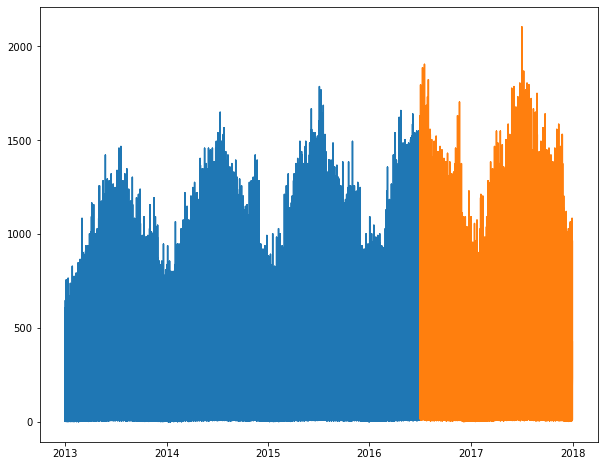

In [39]:
# Lets use 70/30 train test split %
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

# create train and test dataframe
train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.total_price)
plt.plot(test.total_price)

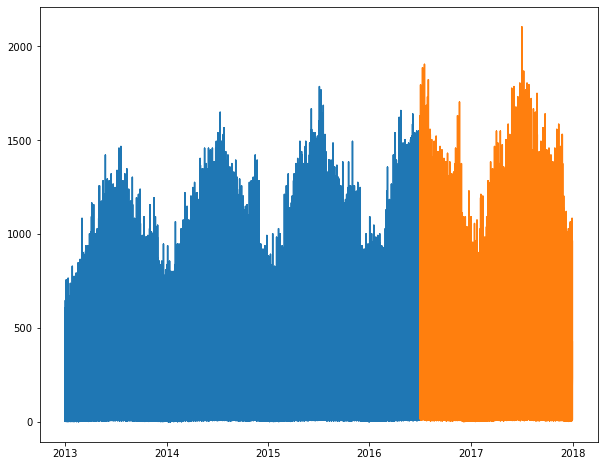

In [40]:
# lets plot train and test

plt.plot(train.index, train.total_price)
plt.plot(test.index, test.total_price)

<AxesSubplot:xlabel='month'>

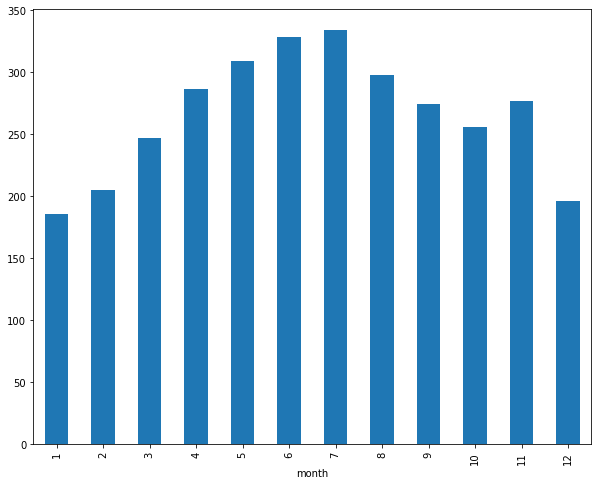

In [41]:

train.groupby('month').total_price.mean().plot.bar()

array([[<AxesSubplot:title={'center':'total_price'}>]], dtype=object)

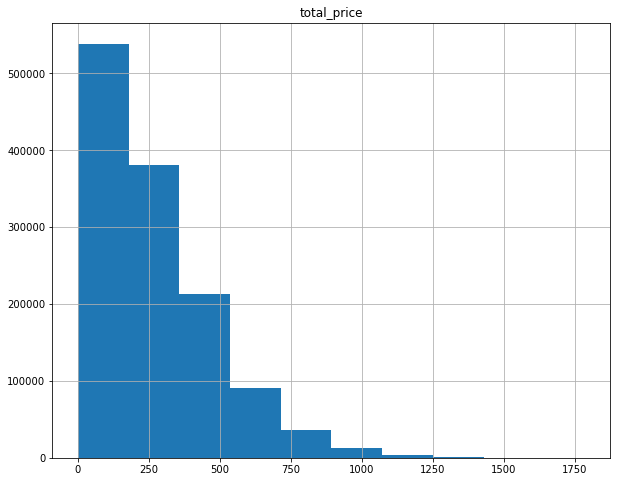

In [42]:
train[['total_price']].hist()

In [43]:

train['month'] = train.index.month
train.head()

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,year,month,weekday,total_price
sale_date,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,13.00,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,2013,1,1,10.92
2013-01-01 00:00:00+00:00,38.00,827179,516 S Flores St,San Antonio,4,TX,78204,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,2013,1,1,176.70
2013-01-01 00:00:00+00:00,33.00,226425,1520 Austin Hwy,San Antonio,5,TX,78218,Garnier Nutritioniste,13,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561,603084234561,2013,1,1,213.51
2013-01-01 00:00:00+00:00,33.00,226425,1520 Austin Hwy,San Antonio,5,TX,78218,Garnier Nutritioniste,13,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561,603084234561,2013,1,1,213.51
2013-01-01 00:00:00+00:00,46.00,224599,516 S Flores St,San Antonio,4,TX,78204,Garnier Nutritioniste,13,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561,603084234561,2013,1,1,297.62


array([[<AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'weekday'}>, <AxesSubplot:>]],
      dtype=object)

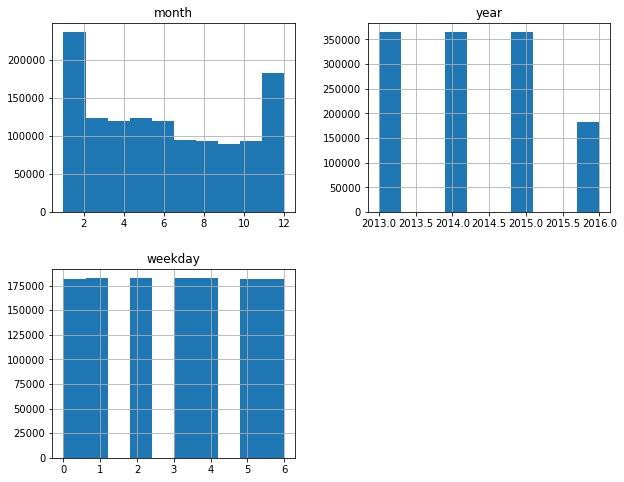

In [44]:
train[['month','year','weekday']].hist()

In [45]:

train.weekday.value_counts()

4    183000
3    183000
2    183000
1    183000
5    182200
6    182000
0    182000
Name: weekday, dtype: int64

<AxesSubplot:xlabel='weekday', ylabel='total_price'>

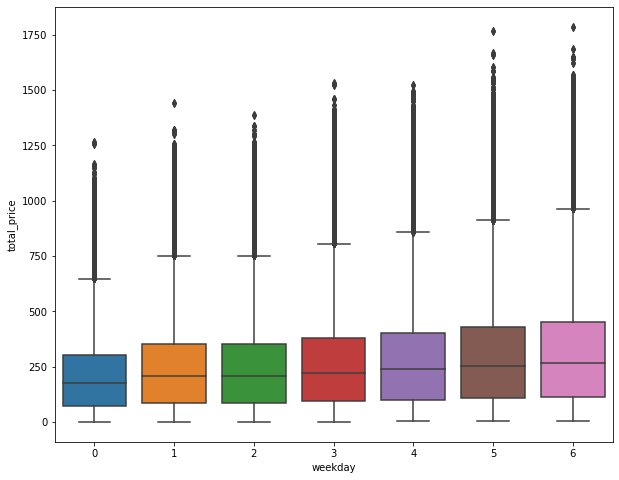

In [46]:
sns.boxplot(data=train, y='total_price',x='weekday')

<AxesSubplot:xlabel='month', ylabel='total_price'>

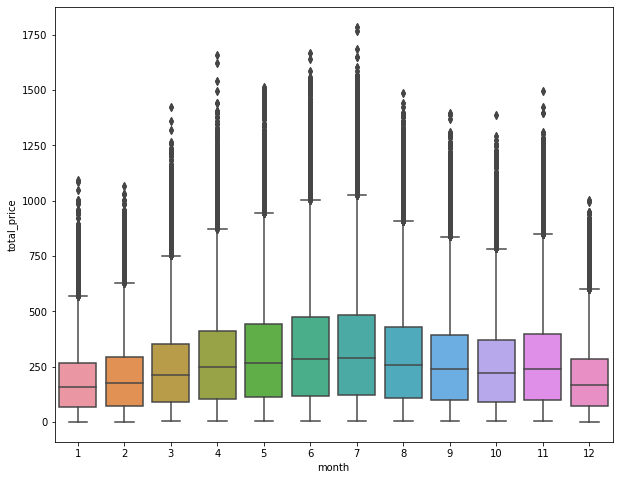

In [47]:
sns.boxplot(data=train, y='total_price',x='month')

<AxesSubplot:xlabel='sale_date'>

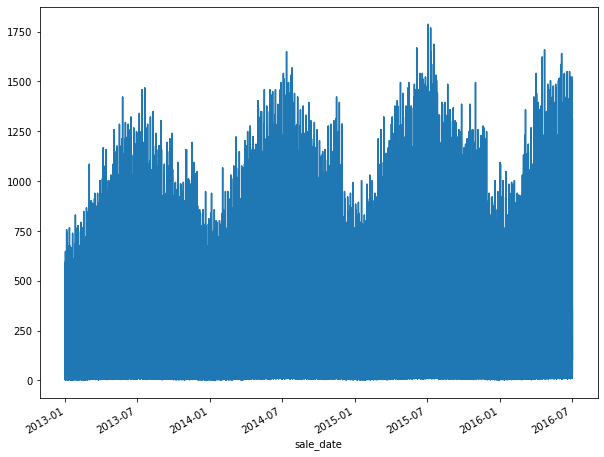

In [48]:
train['total_price'].plot()

In [49]:
y = train[['total_price']]

<AxesSubplot:title={'center':'Monthly Aggregates'}, xlabel='sale_date'>

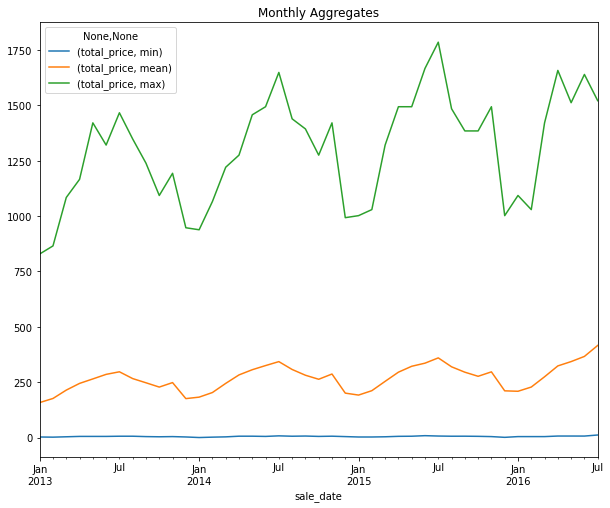

In [50]:
y.resample('M').agg(['min','mean','max']).plot(title='Monthly Aggregates')

<AxesSubplot:title={'center':'Average week-to-week change in total price'}, xlabel='sale_date'>

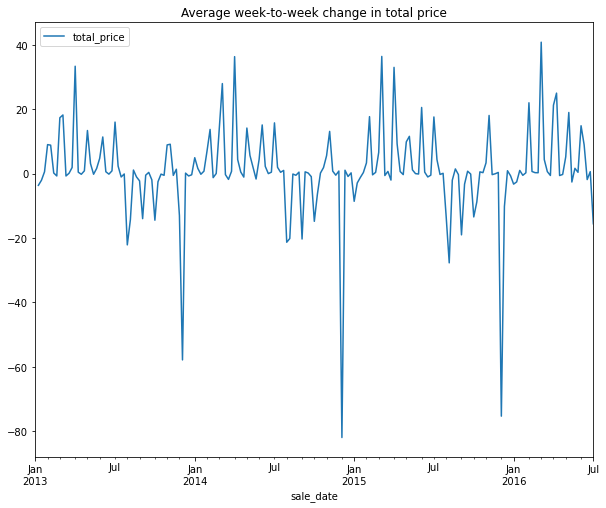

In [51]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in total price')

<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='sale_date'>

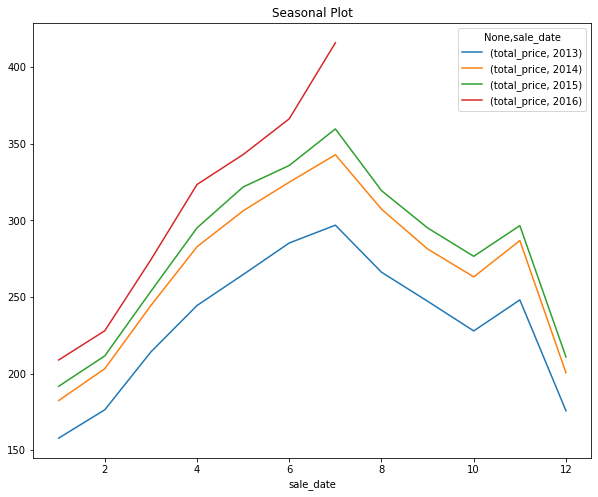

In [52]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

<AxesSubplot:title={'center':'Monthly Aggregates'}, xlabel='sale_date'>

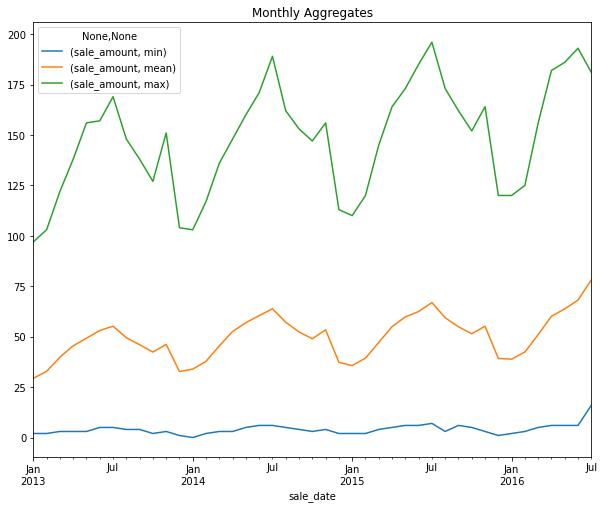

In [53]:
train[['sale_amount']].resample('M').agg(['min','mean','max']).plot(title='Monthly Aggregates')

<AxesSubplot:xlabel='sale_date'>

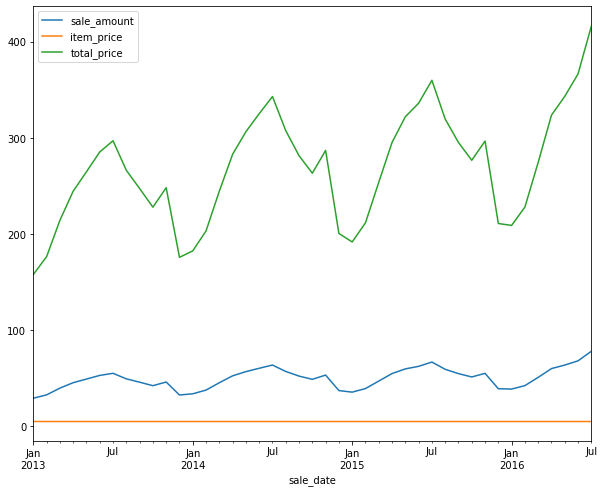

In [54]:
train[['sale_amount','item_price','total_price']].resample('M').mean().plot()

<AxesSubplot:xlabel='sale_date'>

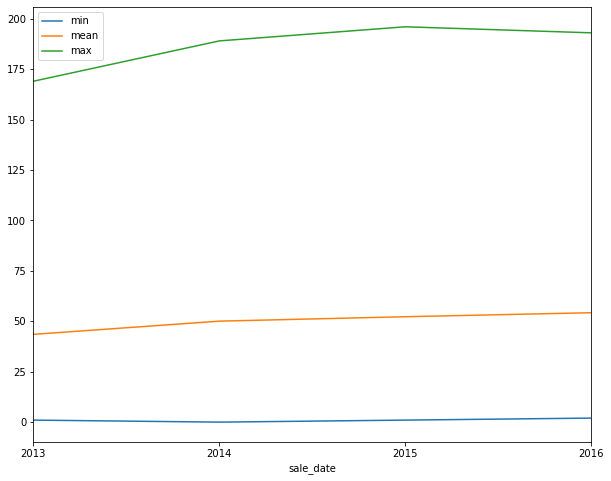

In [55]:
train['sale_amount'].resample('Y').agg(['min','mean','max']).plot()

<AxesSubplot:xlabel='sale_date'>

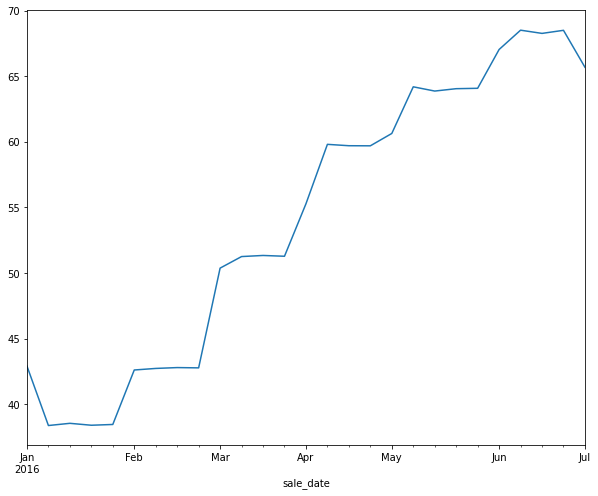

In [56]:
train[train.year==2016].sale_amount.resample('W').mean().plot()


<AxesSubplot:xlabel='sale_date'>

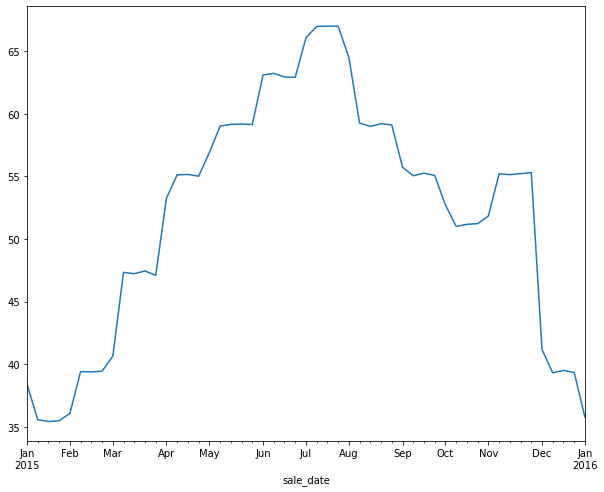

In [57]:
train[train.year==2015].sale_amount.resample('W').mean().plot()


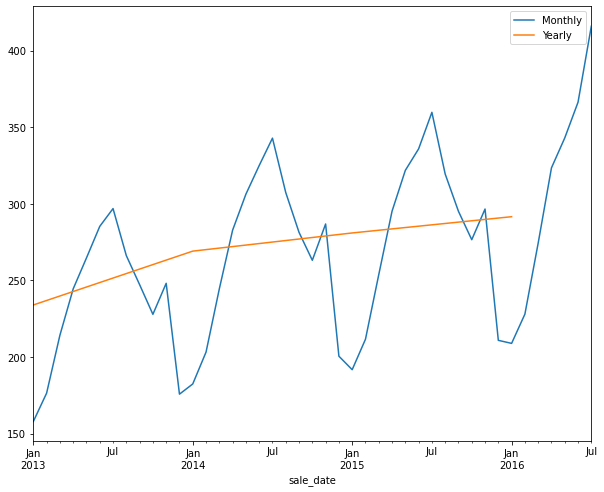

In [59]:
y.resample('M').mean().total_price.plot(label = 'Monthly')
y.resample('Y').mean().total_price.plot(label = 'Yearly')
plt.legend()

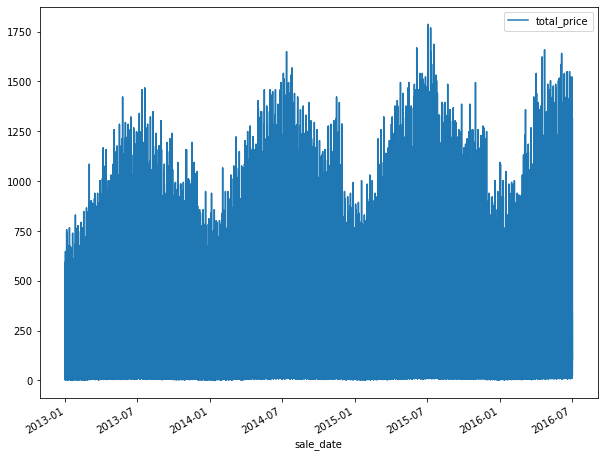

In [60]:
y.plot();

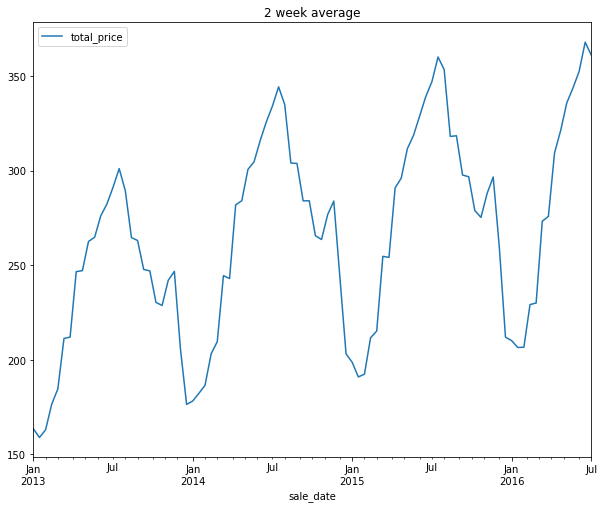

In [61]:

y.resample('2W').mean().plot(title='2 week average');

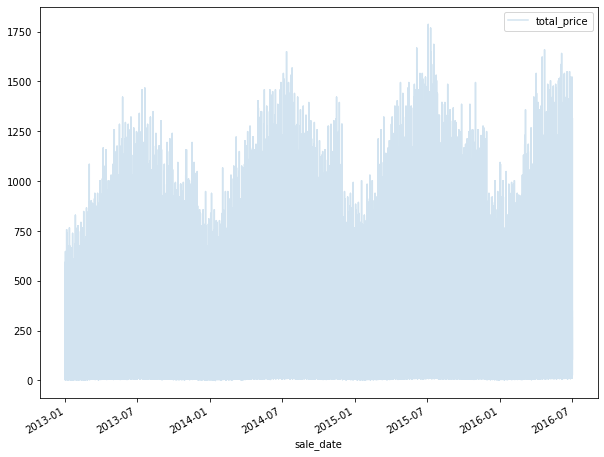

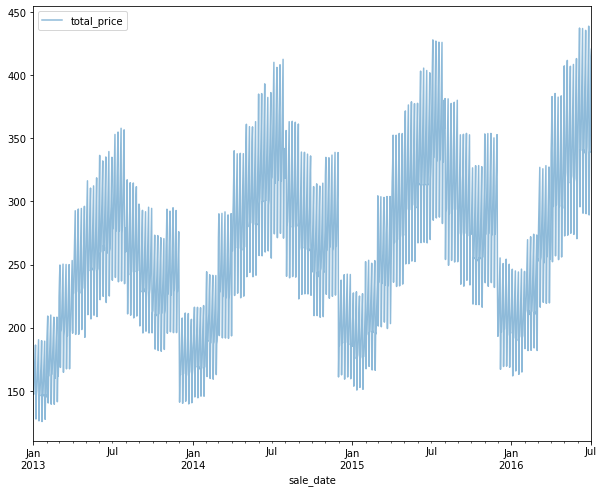

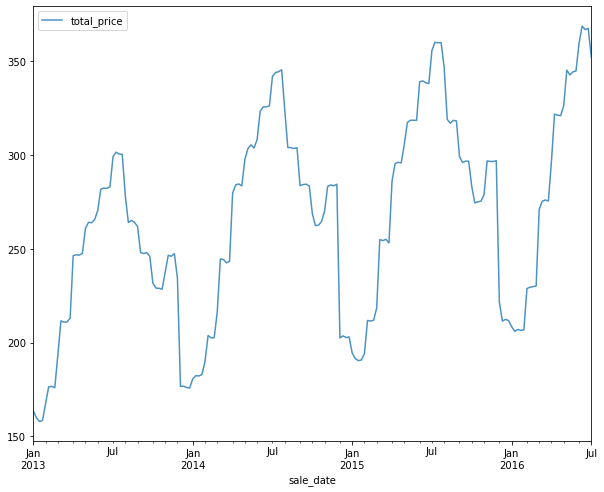

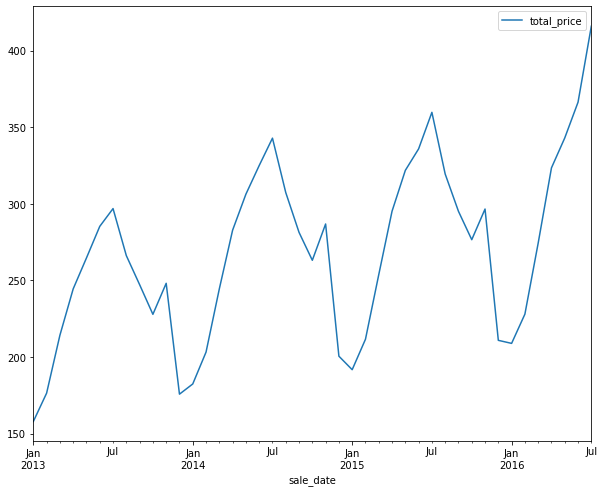

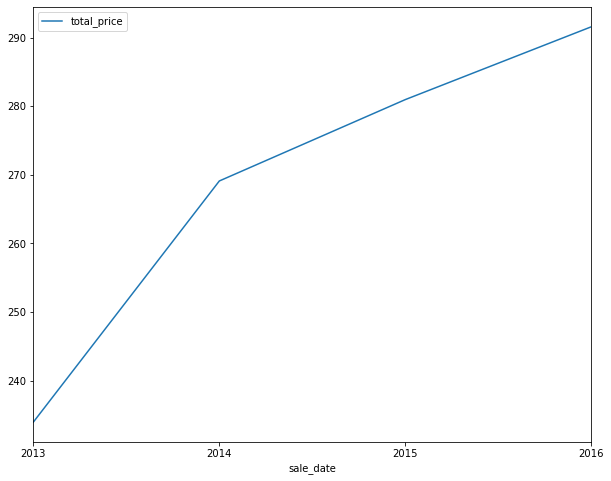

In [62]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

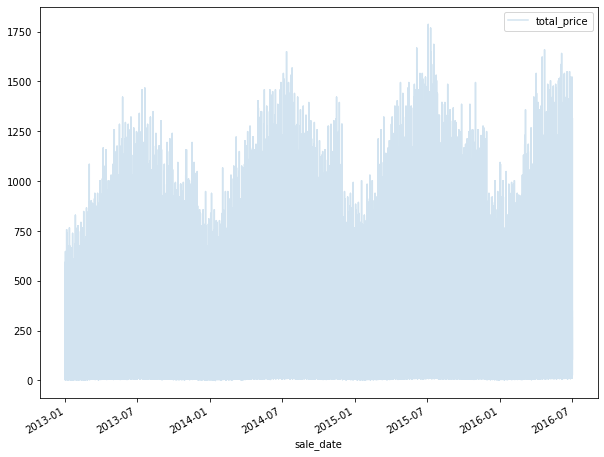

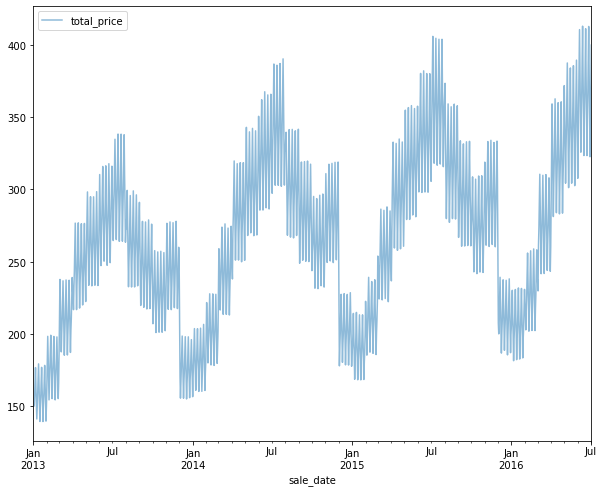

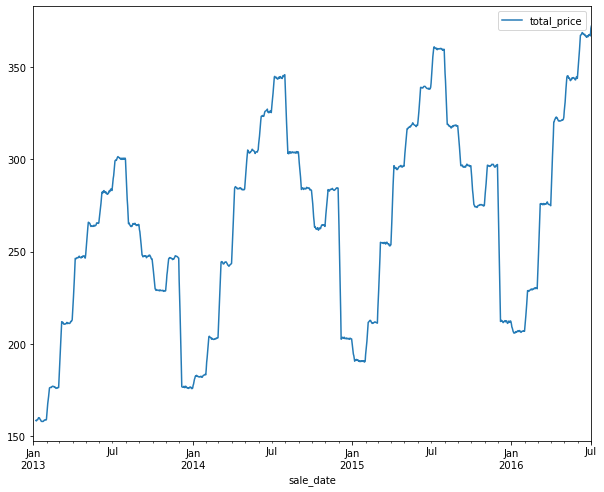

In [63]:
#### We can reduce noise by resampling data the data to longer frequencies.

##Seasonaility to Trend

y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=8, label='1 week')
plt.legend()

# Visualize change over time


In [64]:
y.resample('W').mean().diff()

,total_price
sale_date,
2013-01-06 00:00:00+00:00,nan
2013-01-13 00:00:00+00:00,-3.61
2013-01-20 00:00:00+00:00,-2.03
2013-01-27 00:00:00+00:00,0.60
2013-02-03 00:00:00+00:00,9.04
...,...
2016-06-05 00:00:00+00:00,14.90
2016-06-12 00:00:00+00:00,9.00
2016-06-19 00:00:00+00:00,-1.82


<AxesSubplot:title={'center':'Average week-to-week change in sales'}, xlabel='sale_date'>

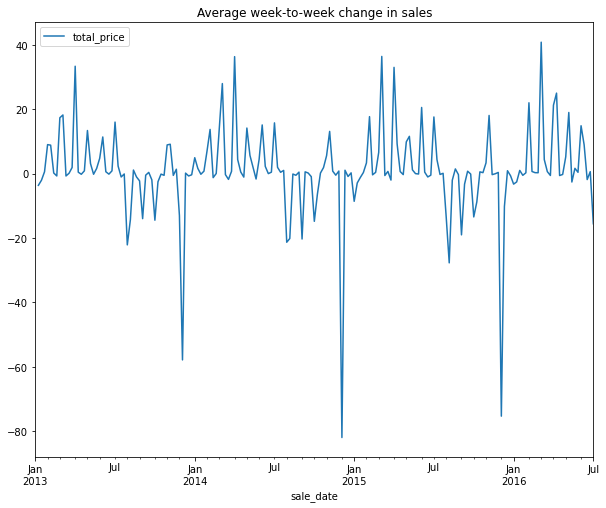

In [65]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in sales')


- Higher weekly sales swings in fall and winter months


<AxesSubplot:title={'center':'Average month-to-month change in sales'}, xlabel='sale_date'>

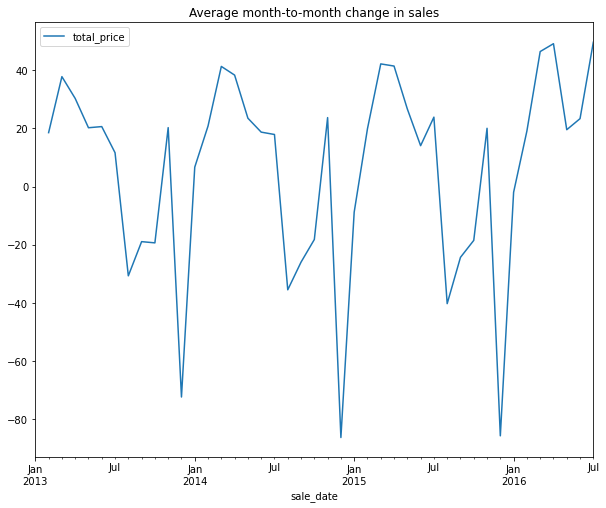

In [66]:

y.resample('M').mean().diff().plot(title='Average month-to-month change in sales')

# Seasonal Plot
comparison of multiple years together.

In [67]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0)


total_price                     
sale_date        2013   2014   2015   2016
sale_date                                 
1              157.89 182.41 191.73 208.90
2              176.41 203.21 211.59 227.98
3              214.18 244.49 253.74 274.37
4              244.46 282.79 295.15 323.46
5              264.66 306.27 321.81 342.99
6              285.26 324.97 335.85 366.32
7              296.88 342.85 359.70 415.93
8              266.18 307.35 319.44    nan
9              247.24 281.35 295.09    nan
10             227.87 263.13 276.57    nan
11             248.11 286.82 296.58    nan
12             175.75 200.54 210.89    nan

<AxesSubplot:xlabel='sale_date'>

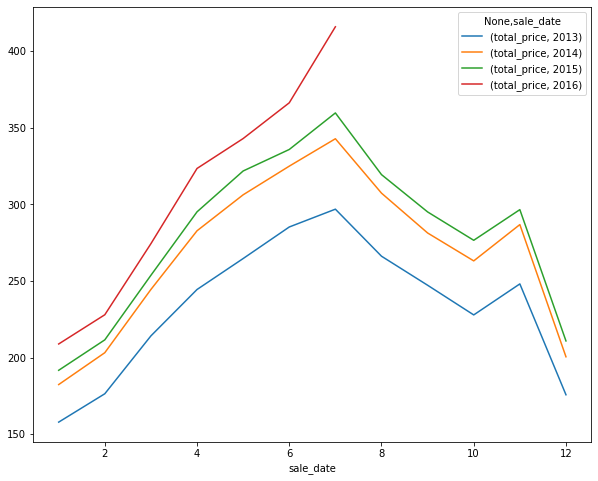

In [68]:
# unstack is similar to pivot_table. It turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot()

Seasonal Subseries Plot
A seasonal subseries plot shows the change year-over-year within each month.

In [69]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()
table

total_price                                                          \
sale_date          1      2      3      4      5      6      7      8      9    
sale_date                                                                       
2013           157.89 176.41 214.18 244.46 264.66 285.26 296.88 266.18 247.24   
2014           182.41 203.21 244.49 282.79 306.27 324.97 342.85 307.35 281.35   
2015           191.73 211.59 253.74 295.15 321.81 335.85 359.70 319.44 295.09   
2016           208.90 227.98 274.37 323.46 342.99 366.32 415.93    nan    nan   

                                
sale_date     10     11     12  
sale_date                       
2013      227.87 248.11 175.75  
2014      263.13 286.82 200.54  
2015      276.57 296.58 210.89  
2016         nan    nan    nan

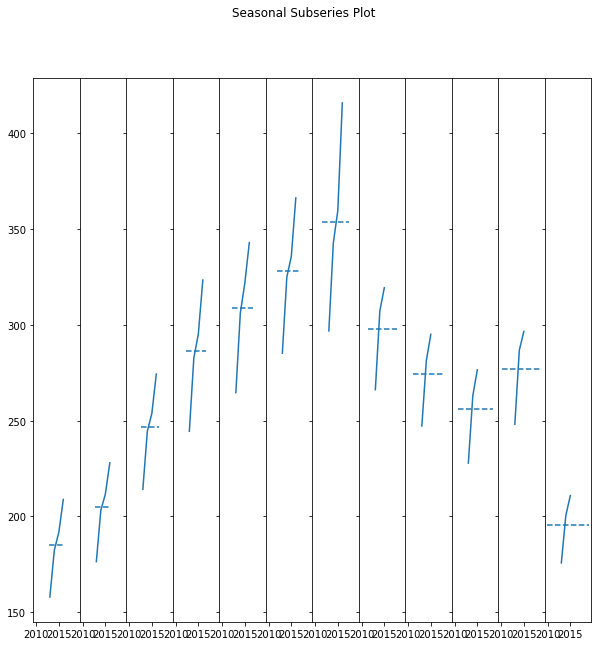

In [71]:
fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, figsize = (10,10))
    x_left, x_right = ax.get_xlim()
    ax.hlines(subset.mean(), x_left, x_right, ls='--')
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

In [72]:
df.shift(-1)

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,year,month,weekday,total_price
sale_date,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,38.00,827179.00,516 S Flores St,San Antonio,4.00,TX,78204.00,Mama Marys,46.00,Pizza Sauce,4.65,35457770664.00,35457770664.00,2013.00,1.00,1.00,176.70
2013-01-01 00:00:00+00:00,33.00,226425.00,1520 Austin Hwy,San Antonio,5.00,TX,78218.00,Garnier Nutritioniste,13.00,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561.00,603084234561.00,2013.00,1.00,1.00,213.51
2013-01-01 00:00:00+00:00,33.00,226425.00,1520 Austin Hwy,San Antonio,5.00,TX,78218.00,Garnier Nutritioniste,13.00,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561.00,603084234561.00,2013.00,1.00,1.00,213.51
2013-01-01 00:00:00+00:00,46.00,224599.00,516 S Flores St,San Antonio,4.00,TX,78204.00,Garnier Nutritioniste,13.00,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561.00,603084234561.00,2013.00,1.00,1.00,297.62
2013-01-01 00:00:00+00:00,46.00,224599.00,516 S Flores St,San Antonio,4.00,TX,78204.00,Garnier Nutritioniste,13.00,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561.00,603084234561.00,2013.00,1.00,1.00,297.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 00:00:00+00:00,70.00,600754.00,735 SW Military Dr,San Antonio,9.00,TX,78221.00,The First Years,33.00,Tomy The First Years Gumdrop Orthodontic Pacif...,6.52,71463060078.00,71463060078.00,2017.00,12.00,6.00,456.40
2017-12-31 00:00:00+00:00,70.00,600754.00,735 SW Military Dr,San Antonio,9.00,TX,78221.00,The First Years,33.00,Tomy The First Years Gumdrop Orthodontic Pacif...,6.52,71463060078.00,71463060078.00,2017.00,12.00,6.00,456.40
2017-12-31 00:00:00+00:00,16.00,611710.00,1520 Austin Hwy,San Antonio,5.00,TX,78218.00,Halls,34.00,Halls Menthol Cough Suppresant/oral Anesthetic...,4.17,312546628694.00,312546628694.00,2017.00,12.00,6.00,66.72


In [73]:
y =df

<AxesSubplot:xlabel='total_price', ylabel='sales_next_day'>

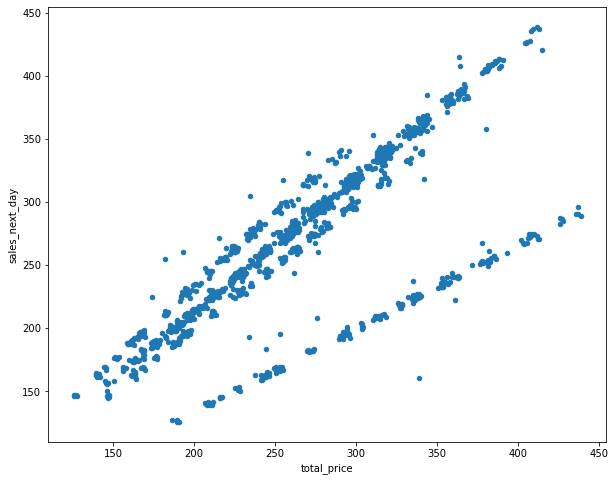

In [78]:
daily = train.resample('D').mean()
daily['sales_next_day'] = daily.total_price.shift(-1)
daily.plot.scatter(x='total_price', y='sales_next_day')

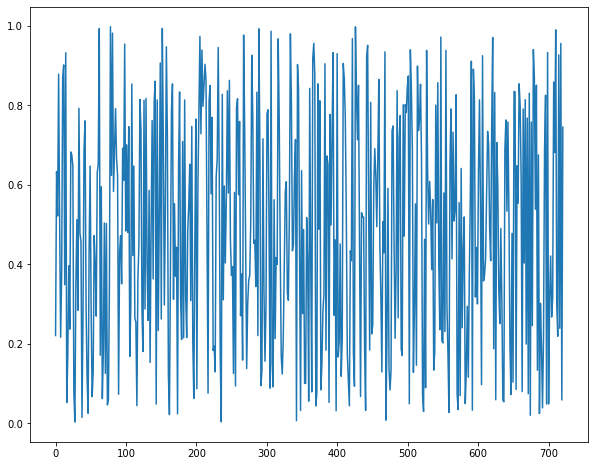

In [80]:
# What does autocorrelation plot look like for white noise
grid = np.linspace(0, 720, 500)
noise = np.random.rand(500)
# result_curve =  noise
plt.plot(grid, noise)

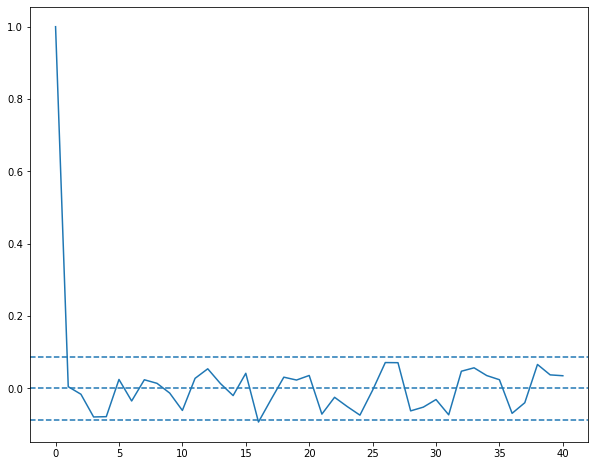

In [81]:
from statsmodels.tsa import stattools

acf_result = stattools.acf(noise)
plt.plot(acf_result)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(noise)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(noise)),linestyle='--')

# Germany

In [30]:
# read csv file. Specify 'datetime' column as index column, parse dates and sort index

germany = acquire_germany()
germany.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18,nan,nan,nan
1,2006-01-02,1380.52,nan,nan,nan
2,2006-01-03,1442.53,nan,nan,nan
3,2006-01-04,1457.22,nan,nan,nan
4,2006-01-05,1477.13,nan,nan,nan


In [31]:
germany =  prepare.missing_zero_values_table(germany)

Your selected dataframe has 5 columns and 4383 Rows.
There are 3 columns that have NULL values.


In [29]:
plt.plot(germany.index, germany.Consumption)

AttributeError: 'DataFrame' object has no attribute 'Consumption'

In [7]:

train_size = .70
n = germany.shape[0]
test_start_index = round(train_size * n)
test_start_index

3068

In [8]:
train = germany[:test_start_index] # everything up (not including) to the test_start_index
test = germany[test_start_index:] # everything from the test_start_index to the end

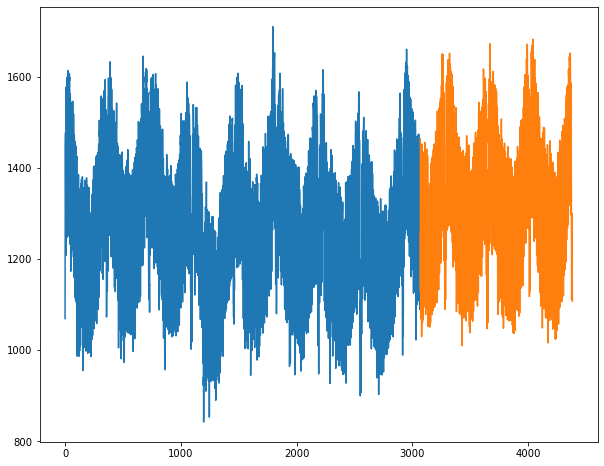

In [10]:
plt.plot(train.index, train.Consumption)
plt.plot(test.index, test.Consumption)

In [14]:
# we will do visualization on train only:
train.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18,nan,nan,nan
1,2006-01-02,1380.52,nan,nan,nan
2,2006-01-03,1442.53,nan,nan,nan
3,2006-01-04,1457.22,nan,nan,nan
4,2006-01-05,1477.13,nan,nan,nan


In [15]:
y = train.Consumption
y.head()

0   1069.18
1   1380.52
2   1442.53
3   1457.22
4   1477.13
Name: Consumption, dtype: float64

<AxesSubplot:ylabel='Frequency'>

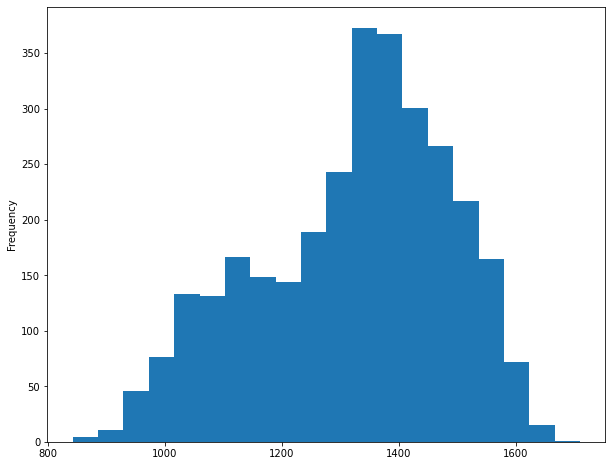

In [16]:
# plot a histogram of consumption
y.plot.hist(bins = 20)